In [2]:
# exploratory analysis
import pandas as pd

# Import data

In [3]:
file='C:/Users/pabma/ClimateTweetSentiment/Sample_Data/Raw/twitter_sentiment_data.csv'
df=pd.read_csv(file)

In [4]:
# raw data
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [5]:
# function for markdown summary export
def dataframe_to_markdown(df, omit_index=True):
    """
    Convert a pandas DataFrame to a Markdown table.
    
    Parameters:
    - df: pandas DataFrame
    - omit_index: boolean, if True omits the DataFrame index in the Markdown table
    
    Returns:
    - markdown_table: str, the DataFrame in Markdown table format
    """
    # Convert the DataFrame to string format
    table = df.to_markdown(index=not omit_index)
    
    return table

In [6]:
# data quality summary
print(dataframe_to_markdown(df.describe().reset_index()))

| index   |    sentiment |         tweetid |
|:--------|-------------:|----------------:|
| count   | 43943        | 43943           |
| mean    |     0.853924 |     8.36797e+17 |
| std     |     0.853543 |     8.56851e+16 |
| min     |    -1        |     5.92633e+17 |
| 25%     |     0        |     7.97038e+17 |
| 50%     |     1        |     8.4023e+17  |
| 75%     |     1        |     9.02e+17    |
| max     |     2        |     9.66702e+17 |


# Target variable: Sentiment

In [7]:
# Sentiment value counts summary
sentiment_count = df['sentiment'].value_counts().reset_index()
sentiment_count.columns = ['sentiment', 'count']
sentiment_count = sentiment_count.sort_values(by='sentiment')

total_count = sentiment_count['count'].sum()
sentiment_count['percentage'] = (sentiment_count['count'] / total_count).round(2)

# Display the updated dataframe
print(dataframe_to_markdown(sentiment_count))

|   sentiment |   count |   percentage |
|------------:|--------:|-------------:|
|          -1 |    3990 |         0.09 |
|           0 |    7715 |         0.18 |
|           1 |   22962 |         0.52 |
|           2 |    9276 |         0.21 |


# Explanatory variables

## 1. Tweetid

In [8]:
# Convert id to datetime
from datetime import *

def tweet_id_to_datetime(tweet_id):
    twitter_epoch = 1288834974657
    timestamp = (tweet_id >> 22) + twitter_epoch
    return datetime.fromtimestamp(timestamp / 1000.0)

# convert to datetime
df['datetime'] = df['tweetid'].apply(tweet_id_to_datetime)

# Add other time-related columns
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['year_month'] = df['datetime'].dt.to_period('M')
df['dayofweek'] = df['datetime'].dt.strftime('%a')

In [9]:
# Summary
# Group by 'year' and calculate count, min_date, and max_date
year_summary = df.groupby('year').agg(
    count=('year', 'size'),
    min_date=('date', 'min'),
    max_date=('date', 'max')
).reset_index()

# Display the summary
year_summary

print(dataframe_to_markdown(year_summary))

|   year |   count | min_date   | max_date   |
|-------:|--------:|:-----------|:-----------|
|   2015 |    3545 | 2015-04-27 | 2015-12-31 |
|   2016 |   14075 | 2016-01-01 | 2016-12-31 |
|   2017 |   19223 | 2017-01-01 | 2017-12-31 |
|   2018 |    7100 | 2018-01-01 | 2018-02-22 |


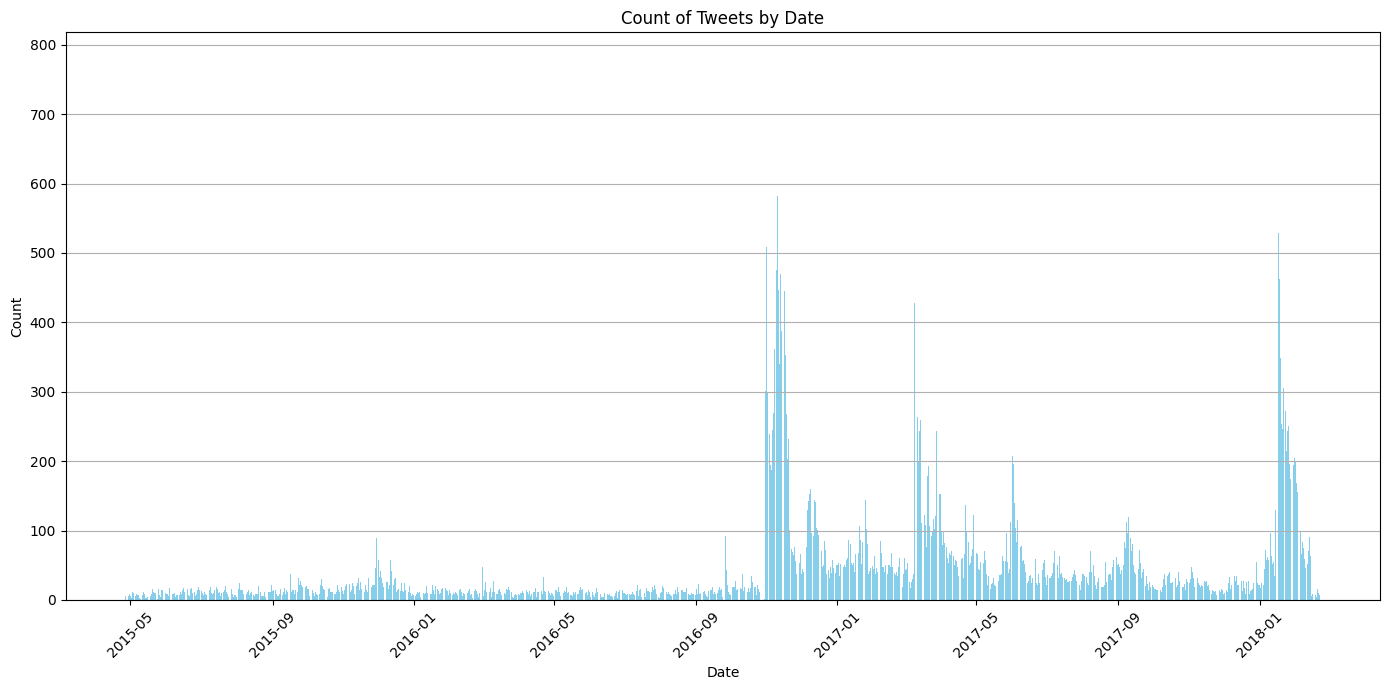

In [10]:
# Barplot of tweets by date
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Group by 'date' and count the number of tweets
date_count = df['date'].value_counts().sort_index().reset_index()
date_count.columns = ['date', 'count']

# Plot count by date as a bar chart
plt.figure(figsize=(14, 7))
plt.bar(date_count['date'], date_count['count'], color='skyblue')
plt.title('Count of Tweets by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 2. Message

In [12]:
# Calculate the length messages
df['message_length'] = df['message'].apply(len)

# Define bins
ini=1
max_bin=200
step=20
bins = list(range(ini, max_bin, step)) + [float('inf')]

# Group by the length bins and count the number of messages in each bin
length_summary = df.groupby(pd.cut(df['message_length'], bins=bins, right=False)).size().reset_index(name='count')

# Rename the columns
length_summary.columns = ['length_range', 'count']

# Display the summary table
print(dataframe_to_markdown(length_summary))

| length_range   |   count |
|:---------------|--------:|
| [1.0, 21.0)    |       7 |
| [21.0, 41.0)   |     305 |
| [41.0, 61.0)   |     896 |
| [61.0, 81.0)   |    2294 |
| [81.0, 101.0)  |    4423 |
| [101.0, 121.0) |    6958 |
| [121.0, 141.0) |   20291 |
| [141.0, 161.0) |    8712 |
| [161.0, 181.0) |      42 |
| [181.0, inf)   |      15 |


C:\Users\pabma\AppData\Local\Temp\ipykernel_15408\956404708.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_summary = df.groupby(pd.cut(df['message_length'], bins=bins, right=False)).size().reset_index(name='count')


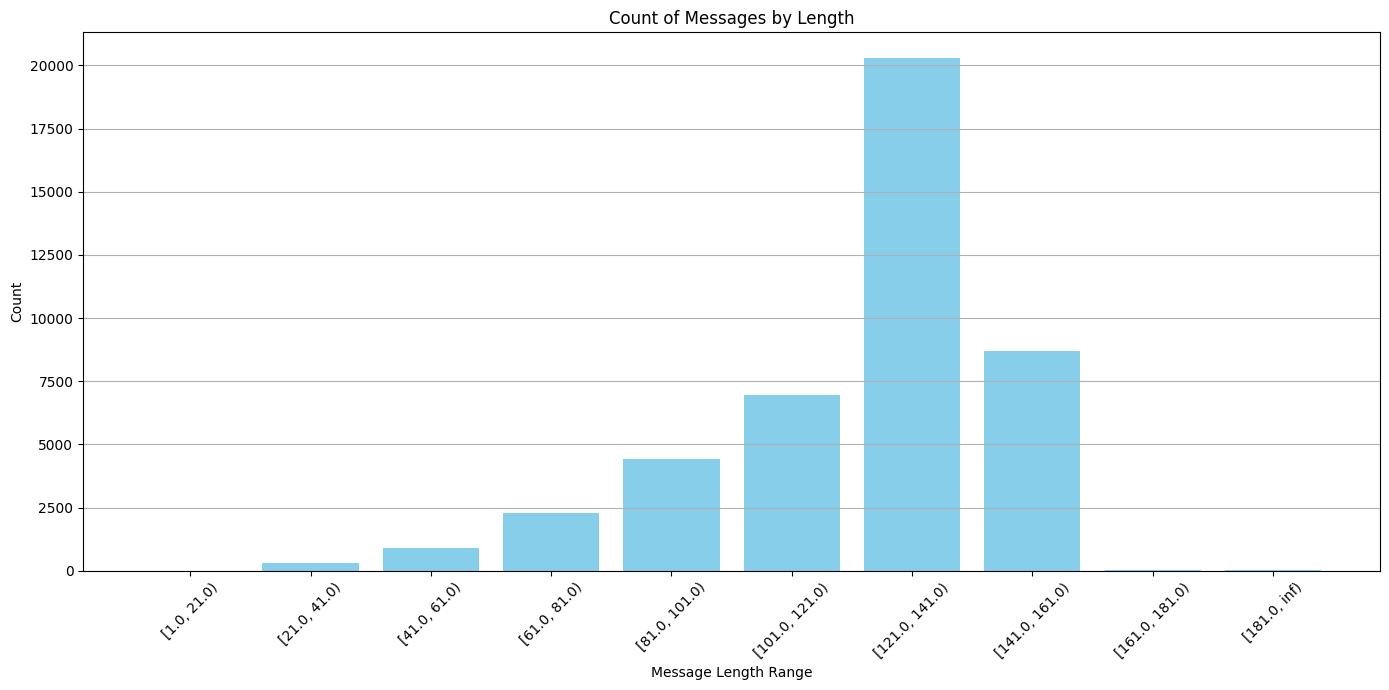

In [13]:
# Plot the bar chart
plt.figure(figsize=(14, 7))
plt.bar(length_summary['length_range'].astype(str), length_summary['count'], color='skyblue')
plt.title('Count of Messages by Length')
plt.xlabel('Message Length Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Tokenize messages and remove stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to preprocess text: tokenize and remove stop words
def preprocess(text):
    tokens = text.lower().split()
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return filtered_tokens

# Apply preprocessing to the messages
df['tokens'] = df['message'].apply(preprocess)

# Calculate word count for each message
df['word_count'] = df['tokens'].apply(len)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pabma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


| word    |   count |
|:--------|--------:|
| climate |   33325 |
| rt      |   25265 |
| change  |   24169 |
| global  |   10477 |
| warming |    7183 |
| trump   |    3535 |
| believe |    2293 |
| us      |    1580 |
| via     |    1557 |
| new     |    1485 |


In [19]:
# Flatten list of all words for frequency calculation
all_words = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_words)

# Get the top 10 words
top_n = 10
top_words = word_counts.most_common(top_n)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

print(dataframe_to_markdown(top_words_df))


| word    |   count |
|:--------|--------:|
| climate |   33325 |
| rt      |   25265 |
| change  |   24169 |
| global  |   10477 |
| warming |    7183 |
| trump   |    3535 |
| believe |    2293 |
| us      |    1580 |
| via     |    1557 |
| new     |    1485 |


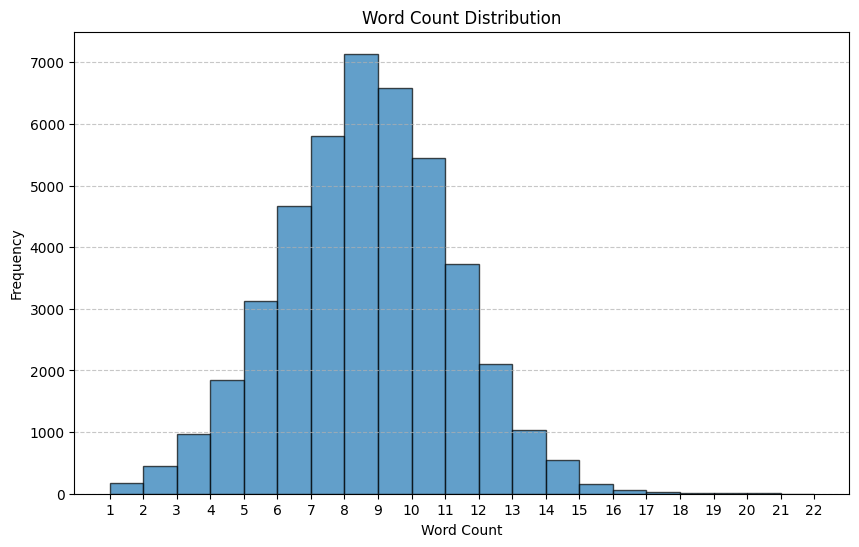

In [20]:
# Plotting the word count distribution
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=range(1, max(df['word_count']) + 2), edgecolor='black', alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1, max(df['word_count']) + 2))
plt.show()

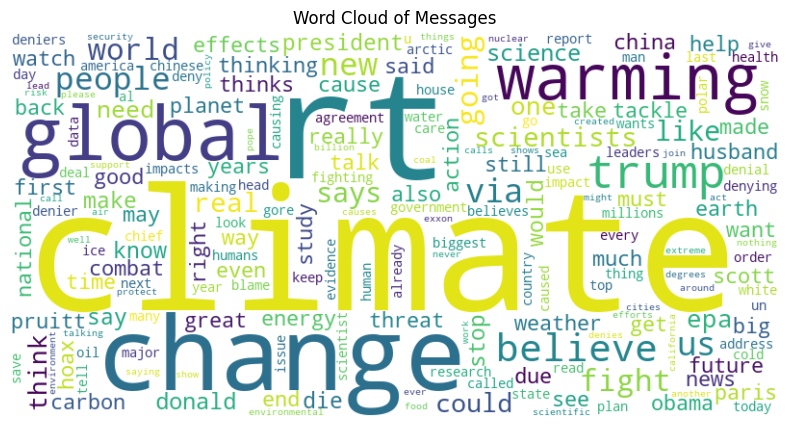

In [22]:
# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Messages')
plt.show()

In [ ]:
# Calculate TF-IDF scores
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['message'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame with TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# Calculate average TF-IDF score for each message
df['average_tfidf'] = tfidf_df.mean(axis=1)


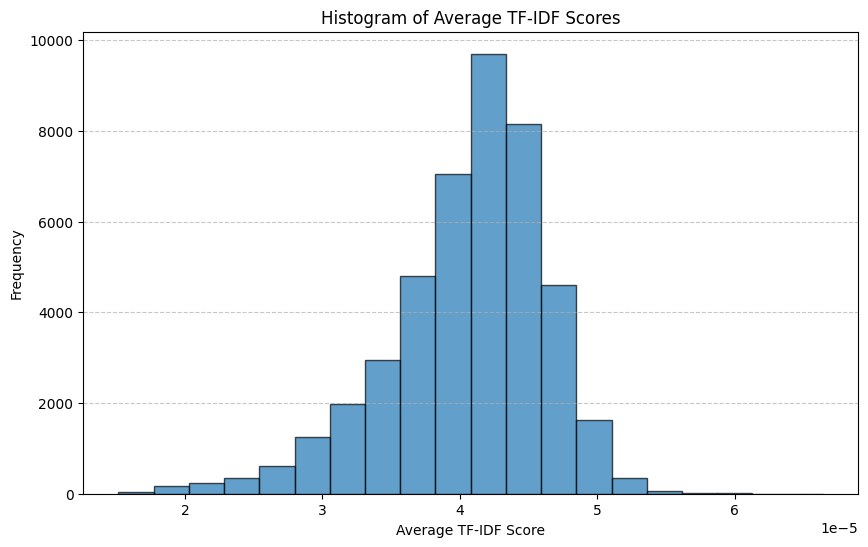

In [23]:
# Plotting the histogram of average TF-IDF scores
plt.figure(figsize=(10, 6))
plt.hist(df['average_tfidf'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Average TF-IDF Scores')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
# Count word frequencies
word_counts = Counter(filtered_words)

# Convert to DataFrame
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Define bins for word count distribution
bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000, float('inf')]
word_counts_df['count_bin'] = pd.cut(word_counts_df['count'], bins=bins, right=False)

# Group by the count bins and summarize
count_distribution = word_counts_df.groupby('count_bin').size().reset_index(name='frequency')

# Display the distribution as a Markdown table
print(dataframe_to_markdown(count_distribution))

| count_bin       |   frequency |
|:----------------|------------:|
| [1.0, 2.0)      |        9478 |
| [2.0, 3.0)      |        2792 |
| [3.0, 4.0)      |        1510 |
| [4.0, 5.0)      |         963 |
| [5.0, 10.0)     |        2172 |
| [10.0, 20.0)    |        1420 |
| [20.0, 50.0)    |        1205 |
| [50.0, 100.0)   |         524 |
| [100.0, 200.0)  |         260 |
| [200.0, 500.0)  |         173 |
| [500.0, 1000.0) |          34 |
| [1000.0, inf)   |          18 |


# Variable ranking

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Select the features and target
features = ['date', 'year', 'month', 'year_month', 'message_length', 'word_count', 'average_tfidf']
X = df[features]
y = df['sentiment']

# Convert categorical features to numeric using one-hot encoding
X_encoded = pd.get_dummies(X, columns=['year_month', 'date'])

# Calculate mutual information (information gain)
info_gain = mutual_info_classif(X_encoded, y, discrete_features=[0, 1, 2, 3, 4])

# Create a DataFrame to display the results
info_gain_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'information_gain': info_gain
})

# Sort the DataFrame by information gain
info_gain_df = info_gain_df.sort_values(by='information_gain', ascending=False)

In [30]:
# Display the results
print(dataframe_to_markdown(info_gain_df[0:10]))

| feature            |   information_gain |
|:-------------------|-------------------:|
| average_tfidf      |         1.18721    |
| message_length     |         0.0747682  |
| word_count         |         0.0261843  |
| month              |         0.0131466  |
| year               |         0.0103976  |
| date_2017-03-06    |         0.00937518 |
| year_month_2016-11 |         0.00877167 |
| year_month_2017-03 |         0.00804246 |
| date_2017-12-29    |         0.00791403 |
| date_2017-05-22    |         0.00737934 |


# Relationship between explanatory variables and target variable

In [31]:
# Create bins for average_tfidf
bins = np.linspace(df['average_tfidf'].min(), df['average_tfidf'].max(), 10)
df['tfidf_bin'] = pd.cut(df['average_tfidf'], bins)

# Count of Sentiment vs. Average TF-IDF Bins (absolute counts)
count_sentiment_tfidf_bin = pd.crosstab(df['tfidf_bin'], df['sentiment']).reset_index()

# Count of Sentiment vs. Average TF-IDF Bins (percentage of total rows)
percent_sentiment_tfidf_bin = pd.crosstab(df['tfidf_bin'], df['sentiment'], normalize='index').round(2).reset_index()

# Display the tables as Markdown
print("Count of Sentiment vs. Average TF-IDF Bins (Absolute Counts):")
print(dataframe_to_markdown(count_sentiment_tfidf_bin))
print("\nCount of Sentiment vs. Average TF-IDF Bins (Percentage of Total Rows):")
print(dataframe_to_markdown(percent_sentiment_tfidf_bin))

Count of Sentiment vs. Average TF-IDF Bins (Absolute Counts):
| tfidf_bin            |   -1 |    0 |     1 |    2 |
|:---------------------|-----:|-----:|------:|-----:|
| (1.52e-05, 2.09e-05] |   24 |  155 |    49 |    2 |
| (2.09e-05, 2.66e-05] |   79 |  476 |   253 |   18 |
| (2.66e-05, 3.22e-05] |  291 | 1018 |  1285 |  335 |
| (3.22e-05, 3.79e-05] |  665 | 1644 |  3601 | 1880 |
| (3.79e-05, 4.36e-05] | 1588 | 2393 | 10160 | 4329 |
| (4.36e-05, 4.93e-05] | 1187 | 1710 |  6927 | 2528 |
| (4.93e-05, 5.5e-05]  |  153 |  276 |   681 |  184 |
| (5.5e-05, 6.07e-05]  |    2 |   31 |     5 |    0 |
| (6.07e-05, 6.64e-05] |    0 |    4 |     0 |    0 |

Count of Sentiment vs. Average TF-IDF Bins (Percentage of Total Rows):
| tfidf_bin            |   -1 |    0 |    1 |    2 |
|:---------------------|-----:|-----:|-----:|-----:|
| (1.52e-05, 2.09e-05] | 0.1  | 0.67 | 0.21 | 0.01 |
| (2.09e-05, 2.66e-05] | 0.1  | 0.58 | 0.31 | 0.02 |
| (2.66e-05, 3.22e-05] | 0.1  | 0.35 | 0.44 | 0.11 |
| (3.22

In [34]:
# Count of Sentiment vs. Year (absolute counts)
count_sentiment_year = pd.crosstab(df['year'], df['sentiment']).reset_index()

# Count of Sentiment vs. Year (percentage of total rows)
percent_sentiment_year = pd.crosstab(df['year'], df['sentiment'], normalize='index').round(2).reset_index()

# Display the tables as Markdown
print("Count of Sentiment vs. Year (Absolute Counts):")
print(dataframe_to_markdown(count_sentiment_year))
print("\nCount of Sentiment vs. Year (Percentage of Total Rows):")
print(dataframe_to_markdown(percent_sentiment_year))

Count of Sentiment vs. Year (Absolute Counts):
|   year |   -1 |    0 |    1 |    2 |
|-------:|-----:|-----:|-----:|-----:|
|   2015 |  454 |  780 | 1467 |  844 |
|   2016 | 1103 | 2269 | 8145 | 2558 |
|   2017 | 1776 | 2986 | 9588 | 4873 |
|   2018 |  657 | 1680 | 3762 | 1001 |

Count of Sentiment vs. Year (Percentage of Total Rows):
|   year |   -1 |    0 |    1 |    2 |
|-------:|-----:|-----:|-----:|-----:|
|   2015 | 0.13 | 0.22 | 0.41 | 0.24 |
|   2016 | 0.08 | 0.16 | 0.58 | 0.18 |
|   2017 | 0.09 | 0.16 | 0.5  | 0.25 |
|   2018 | 0.09 | 0.24 | 0.53 | 0.14 |


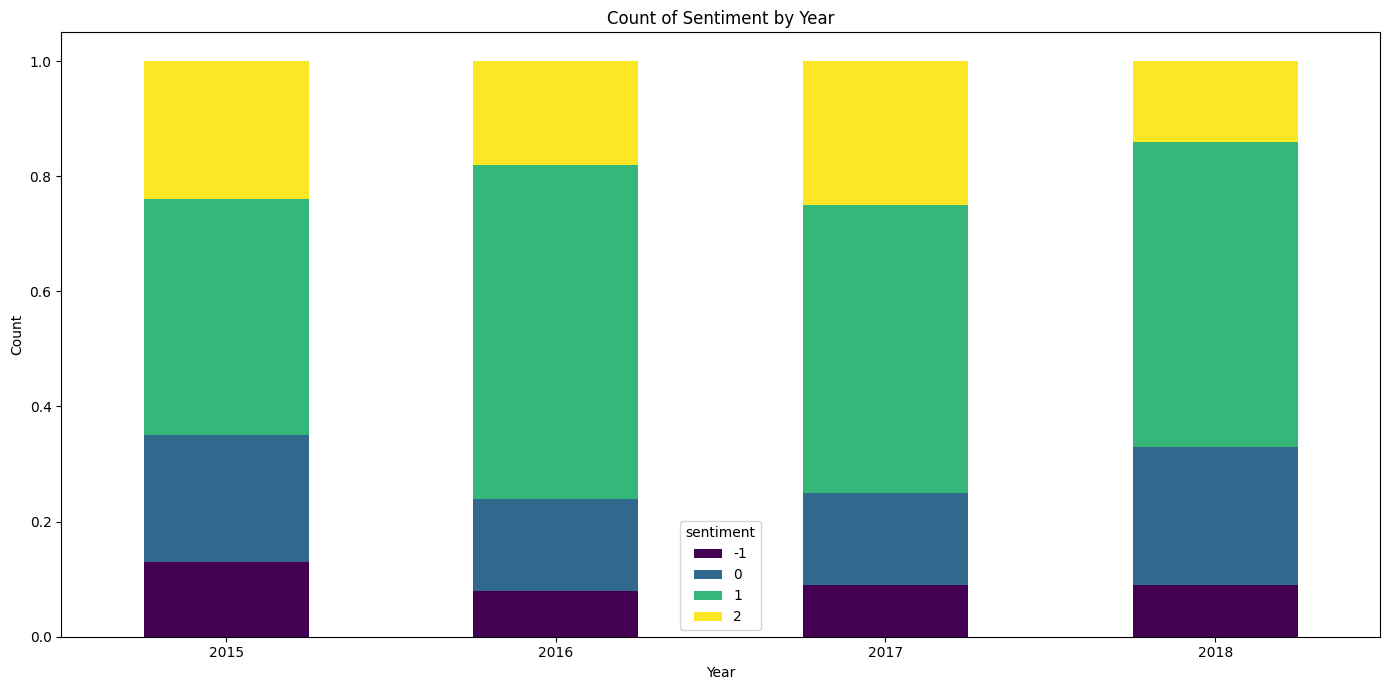

In [35]:
# Plotting Count of Sentiment vs. Year
percent_sentiment_year.plot(kind='bar', x='year', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Count of Sentiment by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [36]:
# Define bins for message lengths in ranges of 20 characters up to 200, with an additional bin for lengths above 200
bins = list(range(0, 201, 20)) + [float('inf')]

# Group by the length bins and sentiment, and count the occurrences
df['length_bin'] = pd.cut(df['message_length'], bins=bins, right=False)

# Count of Sentiment vs. Length of Tweet (absolute counts)
count_sentiment_length = pd.crosstab(df['length_bin'], df['sentiment']).reset_index()

# Count of Sentiment vs. Length of Tweet (percentage of total rows)
percent_sentiment_length = pd.crosstab(df['length_bin'], df['sentiment'], normalize='index').round(2).reset_index()

# Display the tables as Markdown
print("Count of Sentiment vs. Length of Tweet (Absolute Counts):")
print(dataframe_to_markdown(count_sentiment_length))
print("\nCount of Sentiment vs. Length of Tweet (Percentage of Total Rows):")
print(dataframe_to_markdown(percent_sentiment_length))

Count of Sentiment vs. Length of Tweet (Absolute Counts):
| length_bin     |   -1 |    0 |    1 |    2 |
|:---------------|-----:|-----:|-----:|-----:|
| [0.0, 20.0)    |    0 |    5 |    0 |    0 |
| [20.0, 40.0)   |   23 |  219 |   45 |    1 |
| [40.0, 60.0)   |  100 |  503 |  225 |   25 |
| [60.0, 80.0)   |  172 |  929 |  778 |  286 |
| [80.0, 100.0)  |  366 | 1012 | 1619 | 1347 |
| [100.0, 120.0) |  511 |  983 | 2786 | 2437 |
| [120.0, 140.0) | 1365 | 1954 | 7842 | 3299 |
| [140.0, 160.0) | 1446 | 2097 | 9619 | 1875 |
| [160.0, 180.0) |    7 |    7 |   36 |    6 |
| [180.0, 200.0) |    0 |    1 |   10 |    0 |
| [200.0, inf)   |    0 |    5 |    2 |    0 |

Count of Sentiment vs. Length of Tweet (Percentage of Total Rows):
| length_bin     |   -1 |    0 |    1 |    2 |
|:---------------|-----:|-----:|-----:|-----:|
| [0.0, 20.0)    | 0    | 1    | 0    | 0    |
| [20.0, 40.0)   | 0.08 | 0.76 | 0.16 | 0    |
| [40.0, 60.0)   | 0.12 | 0.59 | 0.26 | 0.03 |
| [60.0, 80.0)   | 0.08 | 0.

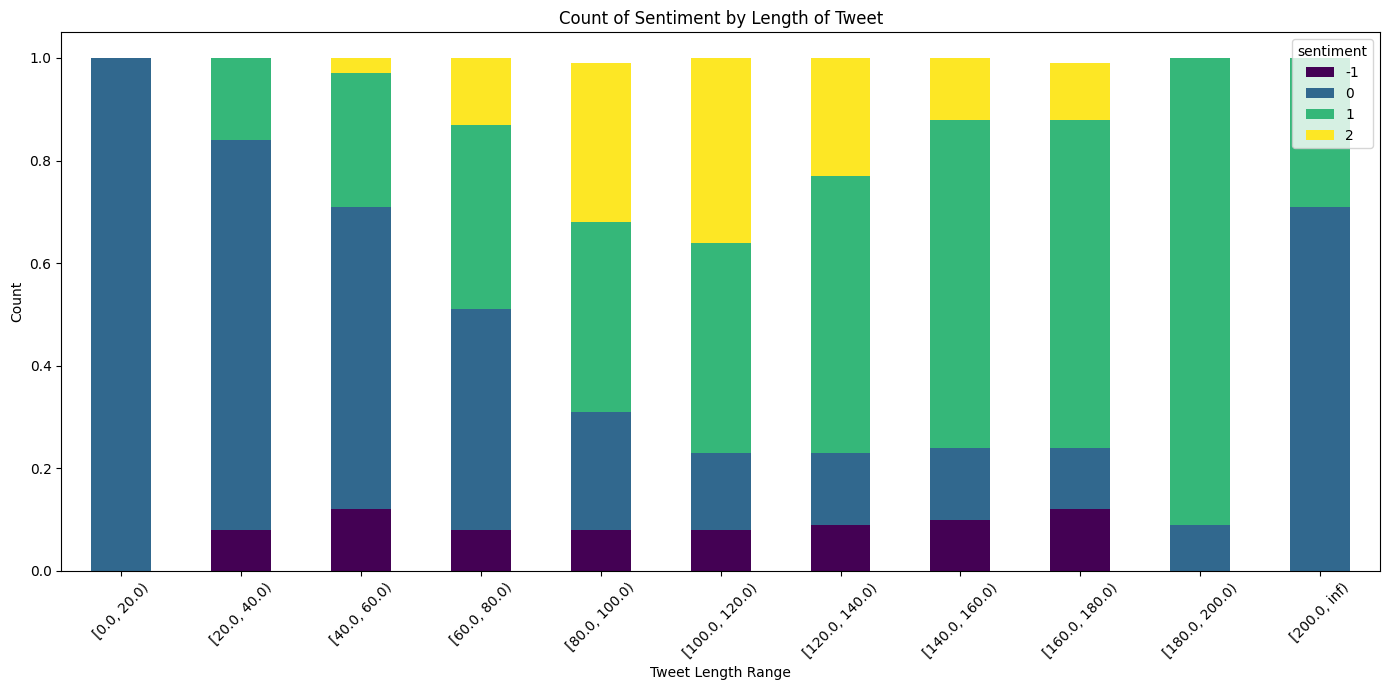

In [37]:
# Plotting Count of Sentiment vs. Length of Tweet
percent_sentiment_length.plot(kind='bar', x='length_bin', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Count of Sentiment by Length of Tweet')
plt.xlabel('Tweet Length Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export dataset with additional features

In [38]:
df.head()

,sentiment,message,tweetid,datetime,date,year,month,day,year_month,dayofweek,message_length,tokens,word_count,average_tfidf,tfidf_bin,length_bin
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,2016-10-30 23:13:07.701,2016-10-30,2016,10,30,2016-10,Sun,137,"[climate, change, interesting, hustle, global,...",12,0.000043,"(3.79e-05, 4.36e-05]","[120.0, 140.0)"
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,2016-10-31 12:15:22.218,2016-10-31,2016,10,31,2016-10,Mon,146,"[rt, watch, right, travels, world, tackle, cli...",8,0.000046,"(4.36e-05, 4.93e-05]","[140.0, 160.0)"
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,2016-10-31 12:16:07.725,2016-10-31,2016,10,31,2016-10,Mon,117,"[leonardo, film, change, via]",4,0.000039,"(3.79e-05, 4.36e-05]","[100.0, 120.0)"
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,2016-10-31 12:17:03.392,2016-10-31,2016,10,31,2016-10,Mon,143,"[rt, watched, amazing, documentary, leonardodi...",7,0.000041,"(3.79e-05, 4.36e-05]","[140.0, 160.0)"
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,2016-10-31 12:19:07.444,2016-10-31,2016,10,31,2016-10,Mon,139,"[rt, pranita, lutheran, gives, testimony, effe...",10,0.000046,"(4.36e-05, 4.93e-05]","[120.0, 140.0)"


In [39]:
# export all except last 2 cols (bins)
df.iloc[:, :-2].to_csv('processed.csv', index=False)

In [42]:
df.columns

Index(['sentiment', 'message', 'tweetid', 'datetime', 'date', 'year', 'month',
       'day', 'year_month', 'dayofweek', 'message_length', 'tokens',
       'word_count', 'average_tfidf', 'tfidf_bin', 'length_bin'],
      dtype='object')